# Gradient Descent

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns
import sklearn
import sklearn.datasets
import sklearn.linear_model
import plotly
import plotly.graph_objs as go

np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

# Set some parameters
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
np.set_printoptions(4)

from plot3d_func import plot_3d

%matplotlib inline

In [2]:
df = pd.read_csv("points.csv", index_col=0)
df.head()

,x,y
0,-5.000000,-7.672309
1,-4.966555,-7.779735
2,-4.933110,-7.995938
3,-4.899666,-8.197059
4,-4.866221,-8.183883


Text(0, 0.5, 'y')

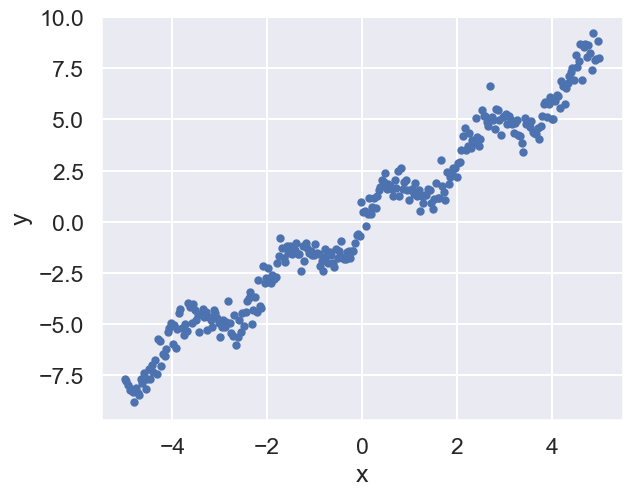

In [3]:
   # Generate a scatter plot using x and y
x = df['x']
y = df['y']

plt.figure(figsize=(6, 5))
plt.scatter(x, y, marker='.')
plt.xlabel('x')
plt.ylabel('y')    

### A Simple Model

The data looks roughly linear, with some extra sinusoidal noise. For now, let's assume that the data follows some underlying linear model. The underlying linear model that predicts the value $y$ using the value $x$ is defined as: $f_{\theta^*}(x) = \theta^* \cdot x$

I will use the dataset to estimate $\theta^*$. I denote an estimate with $\theta$ and the fitted estimated chosen based on the data as $\hat{\theta}$. The parameterized model is:

$$\Large
f_{\theta}(x) = \theta \cdot x
$$

I will define the linear model function `linear_model` below to estimate $\textbf{y}$ (the $y$-values) given $\textbf{x}$ (the $x$-values) and $\theta$.

In [4]:
def linear_model(x, theta):
    # Returns the estimate of y given x and theta
    return theta * x

The squared loss function is smooth and continuous so I will use squared loss to evaluate the estimate $\theta$, which I will use later to identify an optimal $\theta$, denoted $\hat{\theta}$. Given observations $y$ and their corresponding predictions $\hat{y}$, I can compute the average loss:

In [5]:
def average_squared_loss(y, y_hat):
    # Returns the averge squared loss for observations y and predictions y_hat.
    return np.mean((y - y_hat) ** 2)

Finally, I will visualize the average squared loss as a function of $\theta$, where several different values of $\theta$ are given.

Text(0, 0.5, 'Average Loss')

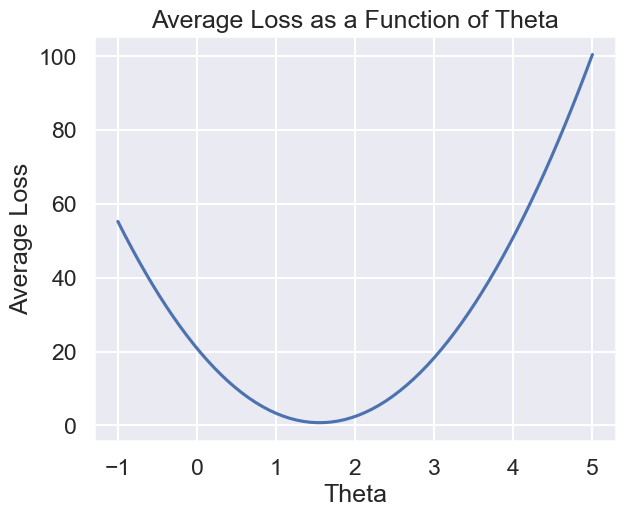

In [6]:
# Plots the average l2 loss for given x, y as a function of theta.
# Use functions for linear_model and l2_loss.
thetas = np.linspace(-1, 5, 70)
avg_loss = np.array([average_squared_loss(linear_model(x, theta), y) for theta in thetas])

plt.figure(figsize=(6,5))
plt.plot(thetas, avg_loss)
plt.title('Average Loss as a Function of Theta')
plt.xlabel("Theta")
plt.ylabel("Average Loss")

### Fitting the Simple Model

The analytical solution for the optimal $\hat{\theta}$ using this model for the average squared loss is: 

$$\hat{\theta} = \frac{\sum_{i=1}^n x_i y_i}{\sum_{i=1}^n x_i^2}$$

Theta is 1.550264808596222


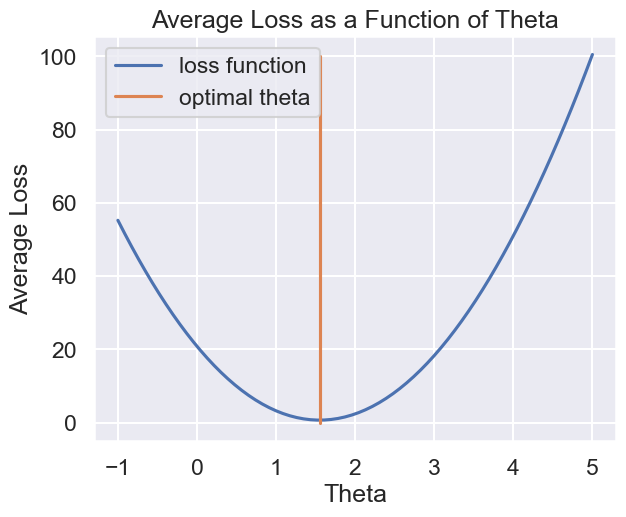

In [7]:
def find_theta(x, y):
    # Find optimal theta given x and y using analytical solution
    return np.sum(x * y)/np.sum(x**2)

theta_hat_simple = find_theta(x, y)

print("Theta is", theta_hat_simple)

plt.figure(figsize=(6,5))
plt.plot(thetas, avg_loss, label='loss function')
plt.plot([theta_hat_simple, theta_hat_simple], [0, 100], label='optimal theta')
plt.title('Average Loss as a Function of Theta')
plt.xlabel("Theta")
plt.ylabel("Average Loss")
plt.legend(loc='upper left')

I now have an optimal value for $\theta$ that minimizes the empirical risk. I can use the scatter plot of the data and add the line $f_{\hat{\theta}}(x) = \hat{\theta} \cdot \textbf{x}$ using the $\hat{\theta}$ computed above.

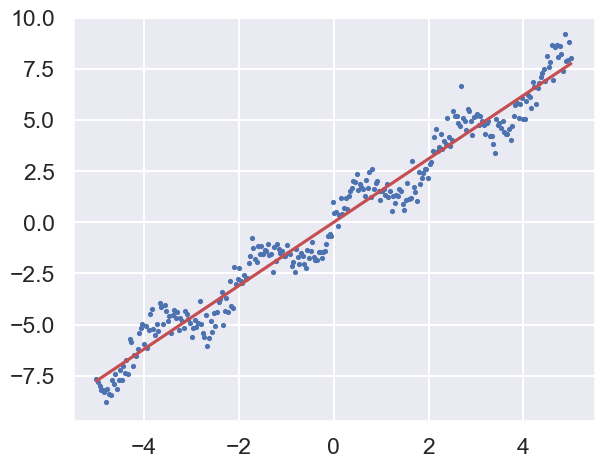

In [8]:
line_values = linear_model(x, theta_hat_simple)
plt.figure(figsize=(6, 5))
plt.plot(x, line_values, color='r')
plt.scatter(x, y, s=5);

It looks like my estimator $f_{\hat{\theta}}(x)$ is able to estimate the average $y$ for each $x$ quite well using a single parameter $\theta$. 

The difference between the true $y$'s and the predictions is known as the residual, $\textbf{r}=\textbf{y}-\hat{\theta} \cdot \textbf{x}$. Below, I find the residual and plot the residuals corresponding to $x$ in a scatter plot. 

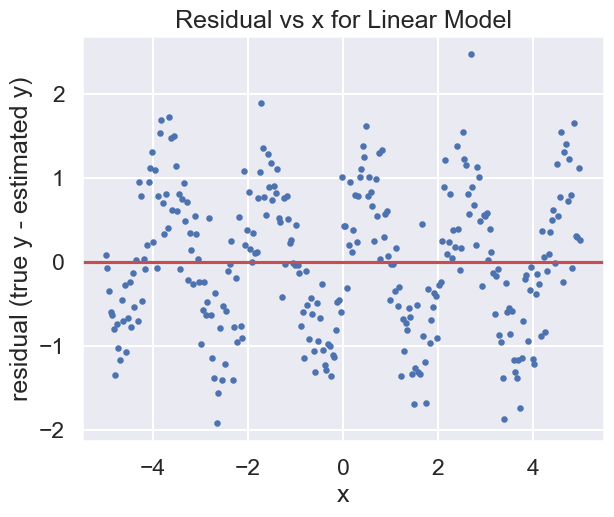

In [9]:
theta_hat = find_theta(x, y)
y_sin = y - linear_model(x, theta_hat)

plt.figure(figsize=(6, 5))
plt.scatter(x, y_sin, s=10)
plt.xlabel('x')
plt.ylabel('residual (true y - estimated y)')
plt.title('Residual vs x for Linear Model')
plt.axhline(y=0, color='r')

### Increasing Model Complexity

It looks like the residual is sinusoidal, meaning the original data follows a linear function and a sinusoidal function. I can create a new model to address this discovery and find optimal parameters to best fit the data:

$$\Large
f_\boldsymbol\theta(x) = \theta_1x + sin(\theta_2x)
$$

The model is parameterized by both $\theta_1$ and $\theta_2$, which I represent in the vector, $\boldsymbol{\theta}$.

Note that a general sine function $a\sin(bx+c)$ has three parameters: amplitude scaling parameter $a$, frequency parameter $b$ and phase shifting parameter $c$. Looking at the residual plot above, it looks like the residual is zero at x = 0, and the residual swings between -1 and 1. Thus, it seems reasonable to effectively set the scaling and phase shifting parameter ($a$ and $c$ in this case) to 1 and 0 respectively. 

In [10]:
def sin_model(x, theta):
    #predicts y using x based on the new equation.
    theta_1 = theta[0]
    theta_2 = theta[1]
    return theta_1 * x + np.sin(theta_2 * x)

The optimal value of $\theta$ should minimize the loss function. One way I can approached solving for $\theta$ is by taking the derivative of the loss function with respect to $\theta$. 
$$R(\textbf{x}, \textbf{y}, \theta_1, \theta_2) = \frac{1}{n} \sum_{i=1}^{n} (\textbf{y}_i - \hat{\textbf{y}_i})^2$$

Therefore the solutions to the minimizing parameters are:

$$\frac{\partial R }{\partial \theta_1} = \frac{2}{n}\sum_{i=1}^n (-x_{i}y_{i} + \theta_{1}x_i^{2} + x_{i}\sin({\theta_{2}x_i}) )$$

$$\frac{\partial R }{\partial \theta_2} = \frac{2}{n}\sum_{i=1}^n (y_i - \theta_{1}x_{i} - \sin({\theta_{2}x_i}))  (-x_{i}\cos({\theta_{2}x_{i}}))$$

In [11]:
def sin_MSE(theta):
    #Compute the numerical value of the l2 loss of the sinusoidal model given theta
    return average_squared_loss(y, sin_model(x, theta))

def sin_MSE_dt1(theta):
    # Compute the numerical value of the partial of l2 loss with respect to theta_1
    sum = np.sum(-x*y+theta[0]*x**2+x*np.sin(theta[1]*x))
    return 2*(sum)/len(x)

def sin_MSE_dt2(theta):
    # Compute the numerical value of the partial of l2 loss with respect to theta_2
    sum = np.sum((y-theta[0]*x-np.sin(theta[1]*x))*(-x*np.cos(theta[1]*x)))
    return 2*(sum)/len(x)
    
def sin_MSE_gradient(theta):
    # calls dt1 and dt2 and returns the gradient dt
    return np.array([sin_MSE_dt1(theta), sin_MSE_dt2(theta)])


### Gradient Descent

There are a number of ways to optimize a linear model:

1. Brute force guess and check
2. Analytically derive a closed form solution
3. Use a numerical method like gradient descent


In this case I want to implement gradient descent. 

$$\large
\boldsymbol\theta^{(t+1)} \leftarrow \boldsymbol\theta^{(t)} - \alpha \left(\nabla_\boldsymbol\theta \mathbf{R}(\textbf{x}, \textbf{y}, \boldsymbol\theta^{(t)}) \right)
$$


In [19]:
def init_theta():
    # Creates an initial theta [0, 0] of shape (2,) as a starting point for gradient descent
    return np.zeros((2,))

def grad_desc(loss_f, gradient_loss_f, theta, num_iter=20, alpha=0.1):
    # Run gradient descent update for a finite number of iterations and static learning rate
    theta_history = []
    loss_history = []

    for i in range(num_iter):
        loss = loss_f(theta)
        gradient = gradient_loss_f(theta)

        theta_history.append(theta)
        loss_history.append(loss)

        # Gradient descent update
        theta = theta - alpha * gradient

    return theta, theta_history, loss_history

theta_start = init_theta()
theta_hat, thetas_used, losses_calculated = grad_desc(sin_MSE, sin_MSE_gradient, theta_start, num_iter=20, alpha=0.1)
for b, l in zip(thetas_used, losses_calculated):
    print(f"theta: {b}, Loss: {l}")

theta: [0. 0.], Loss: 20.859191416422235
theta: [2.6011 2.6011], Loss: 9.285008173048666
theta: [0.9034 2.591 ], Loss: 4.680169273815357
theta: [2.0563 2.9631], Loss: 2.624251793632583
theta: [1.1589 2.8669], Loss: 1.4765157174727803
theta: [1.7939 3.0728], Loss: 0.9073271435862468
theta: [1.3216 3.0015], Loss: 0.541531643291129
theta: [1.6495 3.0291], Loss: 0.37758411424694827
theta: [1.4233 2.9882], Loss: 0.2969750688130763
theta: [1.583  3.0103], Loss: 0.2590425421375735
theta: [1.471  2.9893], Loss: 0.2397343944329184
theta: [1.5504 3.0017], Loss: 0.23034782416254643
theta: [1.4944 2.9914], Loss: 0.2255775832667724
theta: [1.5342 2.998 ], Loss: 0.22321772191904068
theta: [1.506  2.9929], Loss: 0.22202363967204045
theta: [1.526  2.9963], Loss: 0.22142811500262402
theta: [1.5119 2.9938], Loss: 0.22112776381775168
theta: [1.5219 2.9955], Loss: 0.22097741373654575
theta: [1.5148 2.9942], Loss: 0.22090173185683032
theta: [1.5198 2.9951], Loss: 0.2208637810584589


In [20]:
# Run gradient descent update for a finite number of iterations and decaying learning rate
# decaying learning rate helps stabilize learning over time (larger updates at first, smaller refinements later)

def grad_desc_decay(loss_f, gradient_loss_f, theta, num_iter=20, alpha=0.1):
    theta_history = []
    loss_history = []

    for i in range(num_iter):
        loss = loss_f(theta)
        gradient = gradient_loss_f(theta)
        alpha = alpha / (i + 1) # essentially the same as above equation with the addition of this line

        theta_history.append(theta)
        loss_history.append(loss)

        # Gradient descent update with decayed learning rate
        theta = theta - alpha * gradient 
        
    return theta, theta_history, loss_history

theta_start = init_theta()
theta_hat_decay, thetas_used_decay, losses_calculated_decay =  grad_desc_decay(sin_MSE, sin_MSE_gradient, theta_start, num_iter=20, alpha=0.1)
for b, l in zip(thetas_used_decay, losses_calculated_decay):
    print(f"theta: {b}, Loss: {l}")

theta: [0. 0.], Loss: 20.859191416422235
theta: [2.6011 2.6011], Loss: 9.285008173048666
theta: [1.7522 2.596 ], Loss: 0.9288337694245619
theta: [1.7069 2.6273], Loss: 0.763368185887623
theta: [1.6984 2.6348], Loss: 0.733046429075964
theta: [1.6968 2.6363], Loss: 0.7273483828900505
theta: [1.6965 2.6365], Loss: 0.7264098612076508
theta: [1.6965 2.6366], Loss: 0.7262760462559282
theta: [1.6965 2.6366], Loss: 0.7262593239844213
theta: [1.6965 2.6366], Loss: 0.7262574660178012
theta: [1.6965 2.6366], Loss: 0.7262572802218432
theta: [1.6965 2.6366], Loss: 0.7262572633313074
theta: [1.6965 2.6366], Loss: 0.7262572619237625
theta: [1.6965 2.6366], Loss: 0.7262572618154898
theta: [1.6965 2.6366], Loss: 0.7262572618077558
theta: [1.6965 2.6366], Loss: 0.7262572618072402
theta: [1.6965 2.6366], Loss: 0.7262572618072077
theta: [1.6965 2.6366], Loss: 0.7262572618072062
theta: [1.6965 2.6366], Loss: 0.7262572618072062
theta: [1.6965 2.6366], Loss: 0.7262572618072062


Both functions minimize loss but it seems that in this case the constant learning rate of 0.1 optimizes theta. To confirm I want to visually inspect the results of running gradient descent to optimize theta for both functions.

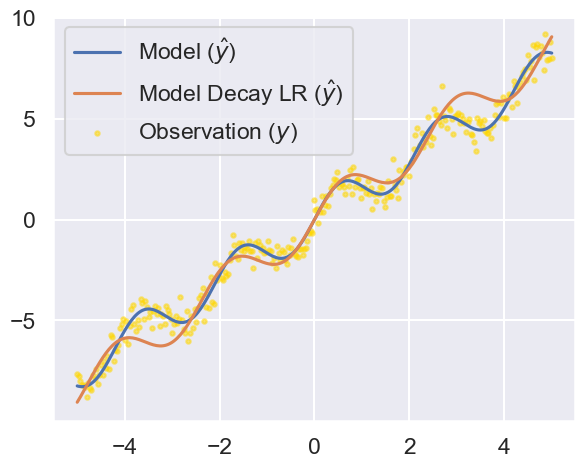

In [21]:
theta_init = init_theta()
theta_est, thetas, loss = grad_desc(sin_MSE, sin_MSE_gradient, theta_init)

theta_init = init_theta()
theta_est_decay, thetas_decay, loss_decay = grad_desc_decay(sin_MSE, sin_MSE_gradient, theta_init)

y_pred = sin_model(x, theta_est)
y_pred_decay = sin_model(x, theta_est_decay)

plt.figure(figsize=(6,5))
plt.plot(x, y_pred, label='Model ($\hat{y}$)')
plt.plot(x, y_pred_decay, label='Model Decay LR ($\hat{y}$)')
plt.scatter(x, y, alpha=0.5, label='Observation ($y$)', color='gold', s=10)
plt.legend();

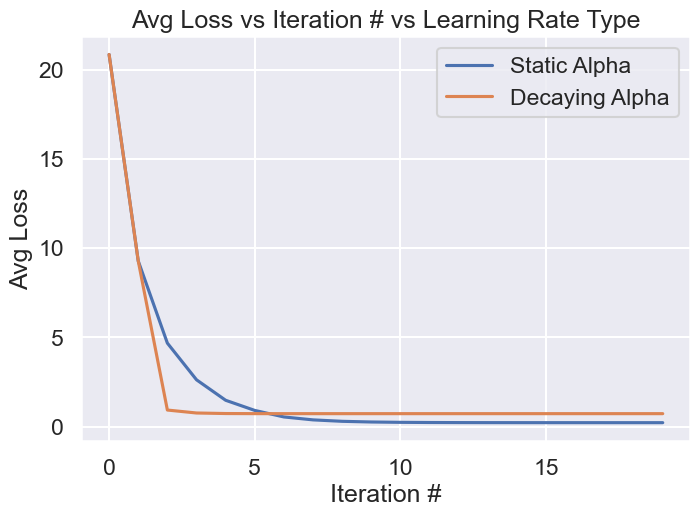

In [22]:
#plot of the loss values over each iteration of gradient descent for both static learning rate and decaying learning rate
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(loss)), loss, label='Static Alpha')
plt.plot(np.arange(len(loss)), loss_decay, label='Decaying Alpha')
plt.xlabel('Iteration #')
plt.ylabel('Avg Loss')
plt.title('Avg Loss vs Iteration # vs Learning Rate Type')
plt.legend();

### Visualizing Loss

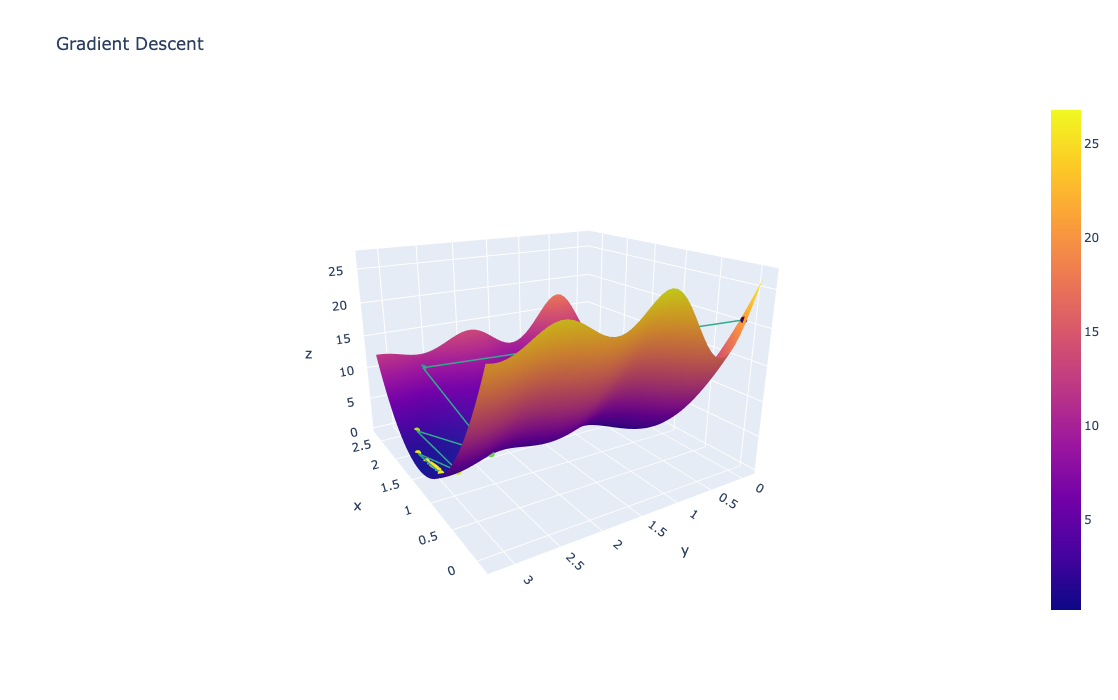

In [23]:
# 3D plot of loss with lr=0.1
thetas = np.array(thetas).squeeze()
loss = np.array(loss)
plot_3d(thetas[:, 0], thetas[:, 1], loss, average_squared_loss, sin_model, x, y)

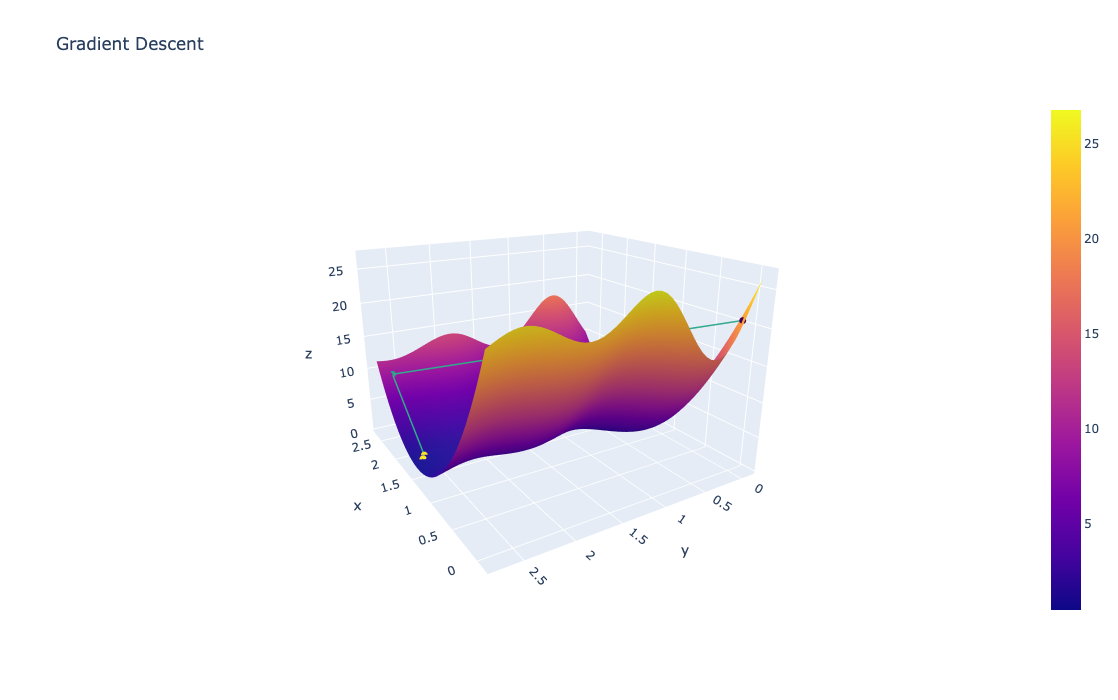

In [24]:
# 3D plot of loss with lr decay
thetas_decay = np.array(thetas_decay).squeeze()
loss_decay = np.array(loss_decay)
plot_3d(thetas_decay[:, 0], thetas_decay[:, 1], loss_decay, average_squared_loss, sin_model, x, y)

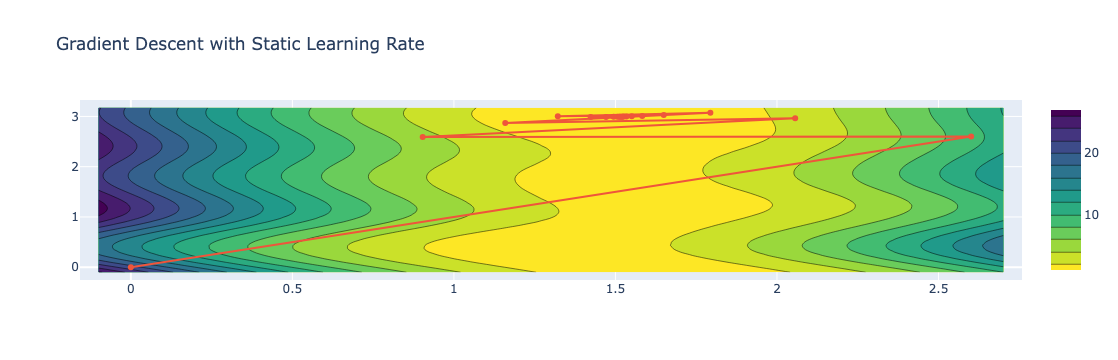

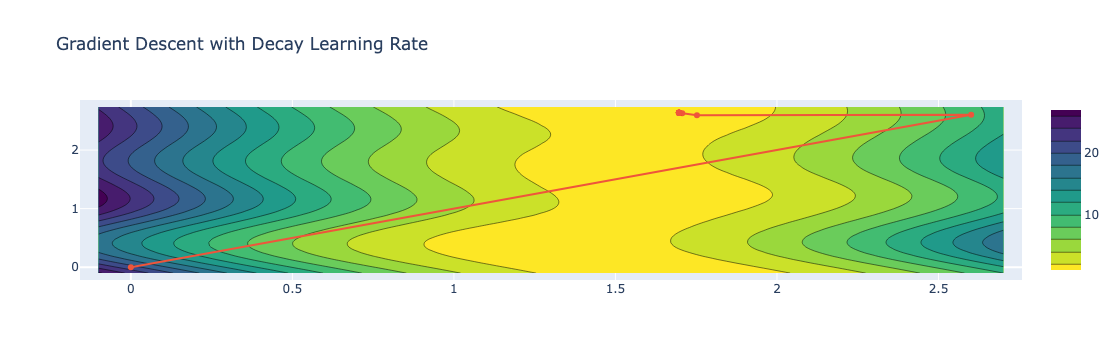

In [25]:
# visulize with contour plot
plotly.offline.init_notebook_mode(connected=True)

def contour_plot(title, theta_history, loss_function, model, x, y):
    """
    The function takes the following as argument:
        theta_history: a (N, 2) array of theta history
        loss: a list or array of loss value
        loss_function: for example, l2_loss
        model: for example, sin_model
        x: the original x input
        y: the original y output
    """
    theta_1_series = theta_history[:,0] # a list or array of theta_1 value
    theta_2_series = theta_history[:,1] # a list or array of theta_2 value

    # generate the z value across a 2D grid
    theta1_s = np.linspace(np.min(theta_1_series) - 0.1, np.max(theta_1_series) + 0.1)
    theta2_s = np.linspace(np.min(theta_2_series) - 0.1, np.max(theta_2_series) + 0.1)

    x_s, y_s = np.meshgrid(theta1_s, theta2_s)
    data = np.stack([x_s.flatten(), y_s.flatten()]).T
    ls = []
    for theta1, theta2 in data:
        l = loss_function(model(x, np.array([theta1, theta2])), y)
        ls.append(l)
    z = np.array(ls).reshape(50, 50)
    
    # Create trace of theta point
    # Create the contour 
    theta_points = go.Scatter(name="theta Values", 
                              x=theta_1_series, 
                              y=theta_2_series,
                              mode="lines+markers")
    lr_loss_contours = go.Contour(x=theta1_s, 
                                  y=theta2_s, 
                                  z=z, 
                                  colorscale='Viridis', reversescale=True)

    plotly.offline.iplot(go.Figure(data=[lr_loss_contours, theta_points], layout={'title': title}))

contour_plot('Gradient Descent with Static Learning Rate', thetas, average_squared_loss, sin_model, x, y)
contour_plot('Gradient Descent with Decay Learning Rate', thetas_decay, average_squared_loss, sin_model, x, y)